In [32]:
import datetime as dt
# import holidays       
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
price = pd.read_csv('price.csv', parse_dates=True, index_col='Month')

In [34]:
price.head()

,price
Month,
1964-01-01,4315
1964-02-01,4172
1964-03-01,4255
1964-04-01,4221
1964-05-01,4446


In [35]:
price.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [36]:
price['price'].isna().sum()
#No na values

0

<Axes: xlabel='Month'>

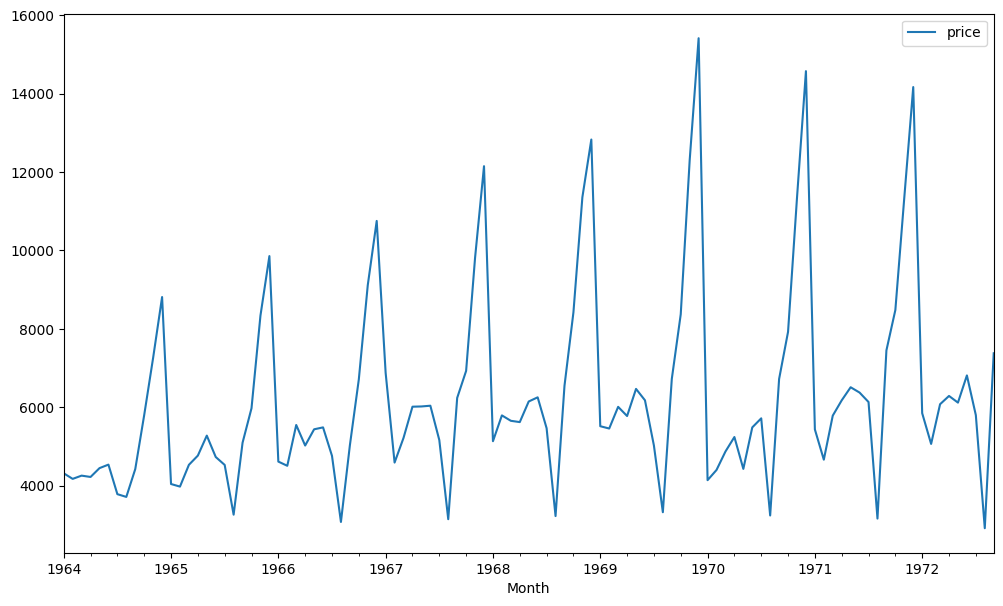

In [37]:
price.plot(figsize=(12, 7))

In [38]:
# seasonality appears at every 12 months

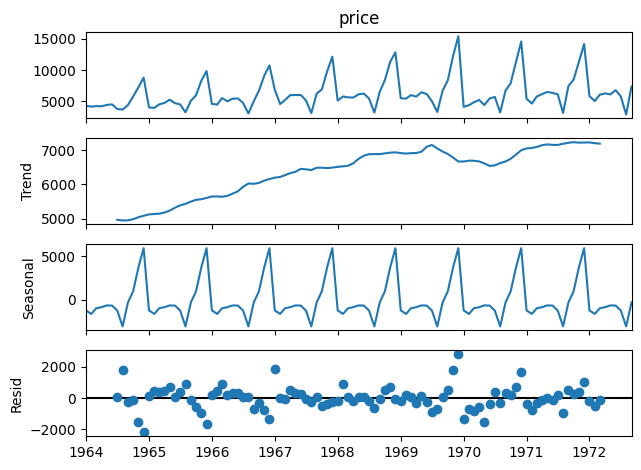

In [39]:
seasonal_decompose(price['price']).plot();

In [40]:
adf = adfuller(price['price'], autolag='AIC')

In [41]:
{'Test_stats':adf[0], 'p value': adf[1]}

{'Test_stats': -1.8335930563276344, 'p value': 0.36391577166023953}

In [42]:
# not stationary (p value = 0.3639)

In [43]:
price['one_shift'] = price['price'].shift(1)
adf = adfuller(price['price'].iloc[1:]-price['one_shift'].dropna(), autolag = 'AIC') #loc 1: because the first shift leads to one NA value in the original dataset
{'Test_stats':adf[0], 'p value': adf[1]}

{'Test_stats': -7.189896448050991, 'p value': 2.5196204473871814e-10}

In [44]:
# P value lesser than 0.05 -> stationary

In [45]:
price['one_shift_diff']=price['price'].iloc[1:]-price['one_shift'].dropna()

<Axes: xlabel='Month'>

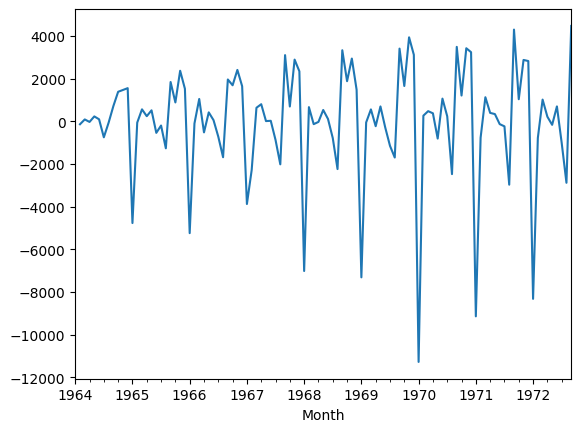

In [46]:
price['one_shift_diff'].plot()

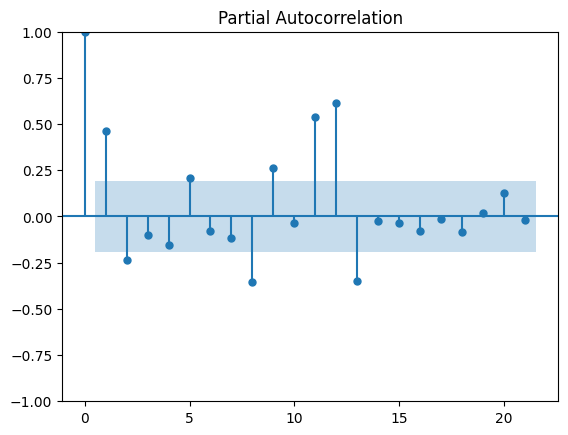

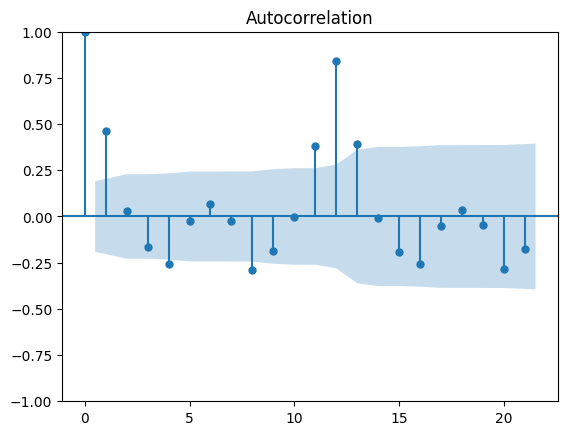

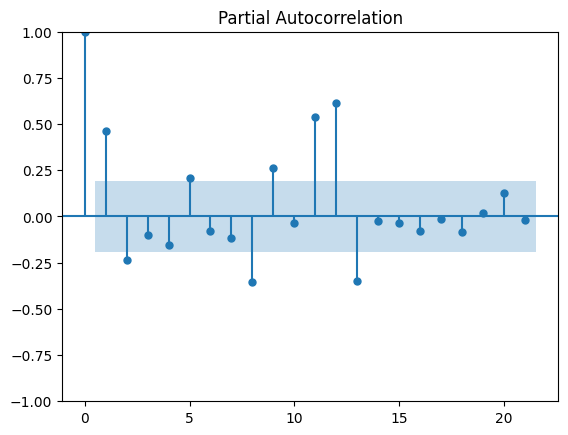

In [47]:
# on original data

plot_acf(price['price'])
plot_pacf(price['price'])

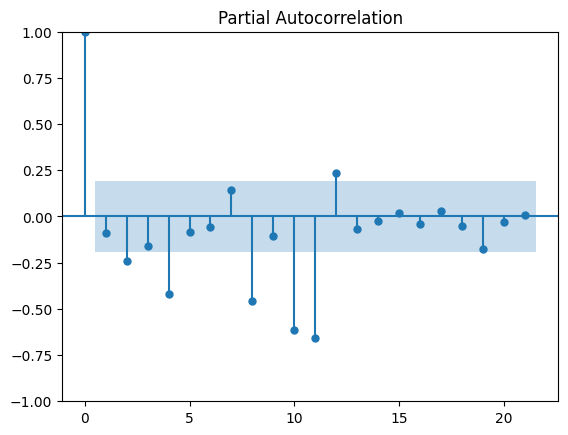

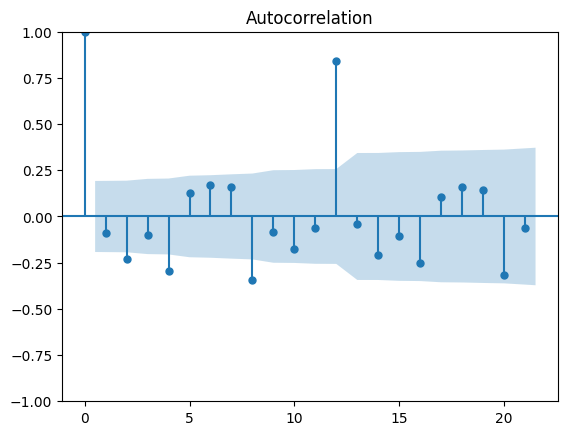

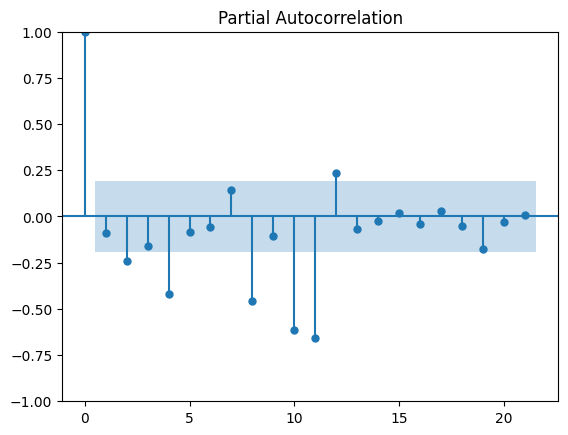

In [48]:
# on stationary data

plot_acf(price['one_shift_diff'].dropna())
plot_pacf(price['one_shift_diff'].dropna())

In [49]:
model = ARIMA(price['price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) #periodicity = 12, i.e., seasonal trends occur every 1 year/12 months, S = 12
# from pacf, acf on original data, p = q = 1. one-shift difference was taken so d = 1

c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [50]:
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            price   No. Observations:                  105
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -739.403
Date:                          Wed, 11 Oct 2023   AIC                           1488.805
Time:                                  14:40:41   BIC                           1501.414
Sample:                              01-01-1964   HQIC                          1493.894
                                   - 09-01-1972                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2924      0.078      3.731      0.000       0.139       0.446
ma.L1         -0.9471      0.043    -22.053      0.000      -1.031      -0.863
ar.S.L12      -0.4223      0.312     -1.352      0.176      -1.035       0.190
ma.S.L12       0.2230      0.317      0.703      0.482      -0.398       0.845
sigma2      5.049e+05   6.08e+04      8.310      0.000    3.86e+05    6.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 8.69
Prob(Q):                              0.54   Prob(JB):                         0.01
Heteroskedasticity (H):               1.09   Skew:                            -0.21
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
model_fit.predict()

1964-01-01       0.000000
1964-02-01    3889.359259
1964-03-01    4002.027623
1964-04-01    4163.195046
1964-05-01    4184.483649
                 ...     
1972-05-01    6283.390089
1972-06-01    6380.167574
1972-07-01    6475.767249
1972-08-01    3251.642883
1972-09-01    7376.236306
Freq: MS, Name: predicted_mean, Length: 105, dtype: float64

In [52]:
from sklearn.metrics import mean_squared_error
mean_squared_error(price['price'].iloc[1:], model_fit.predict()[1:])

1041721.9727662827

In [53]:
sarimax_model = SARIMAX(price['price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit() #There is a seasonality of 12 months, so trying to predict using SARIMAX as well

c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [54]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -739.403
Date:                            Wed, 11 Oct 2023   AIC                           1488.805
Time:                                    14:40:43   BIC                           1501.414
Sample:                                01-01-1964   HQIC                          1493.894
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2924      0.078      3.731      0.000       0.139       0.446
ma.L1         -0.9471      0.043    -22.053      0.000      -1.031      -0.863
ar.S.L12      -0.4223      0.312     -1.352      0.176      -1.035       0.190
ma.S.L12       0.2230      0.317      0.703      0.482      -0.398       0.845
sigma2      5.049e+05   6.08e+04      8.310      0.000    3.86e+05    6.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 8.69
Prob(Q):                              0.54   Prob(JB):                         0.01
Heteroskedasticity (H):               1.09   Skew:                            -0.21
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
sarimax_model.predict(105)

1972-10-01    8522.935984
Freq: MS, dtype: float64

In [56]:
mean_squared_error(price['price'].iloc[1:], sarimax_model.predict()[1:])

1041721.9727662827

In [57]:
dates = pd.date_range(start='01-10-1972', end='01-11-1980', freq='M')
# len(dates), dates # -> Uncommment if dates are to be viewed

In [58]:
newDf = pd.DataFrame(data=[sarimax_model.predict(i).iloc[0] for i in range (105, 105+96)])

In [59]:
newDf.columns = ['future_price']

In [60]:
newDf.index = dates

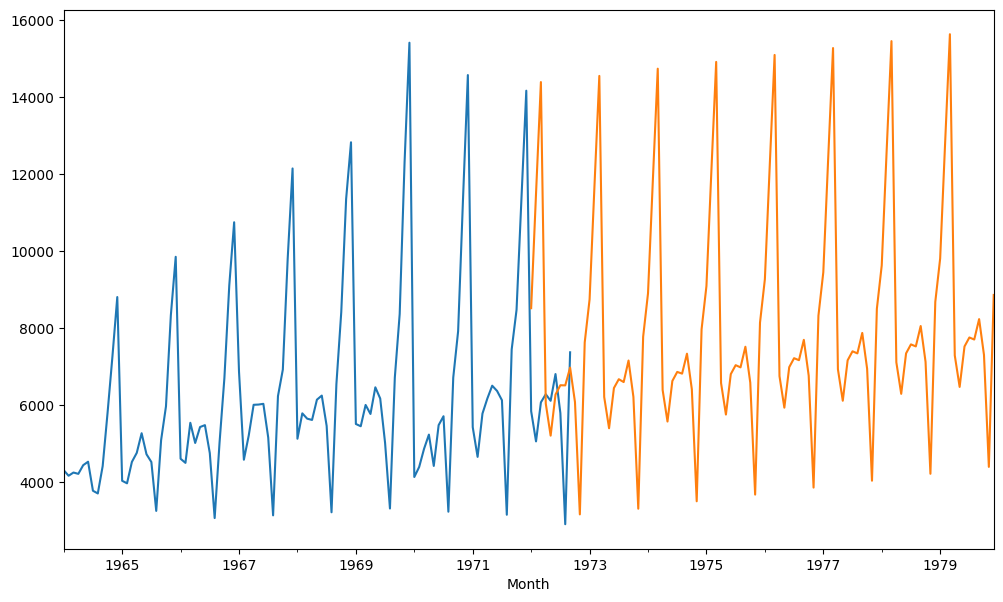

In [61]:
price['price'].plot(figsize=(12, 7))
newDf['future_price'].plot(figsize=(12, 7))
plt.show()